In [10]:
import requests
import os
import zipfile
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as smm
import matplotlib
import matplotlib.pyplot as plt

In [3]:
#let's download and import the feature table directly from the FBMN job in GNPS2
task_id = 'ed2d2cd94179481d818356271bd7762f'
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = '/.../directory_path/'

#import the metadata
metadata = pd.read_csv('/.../MSV000082261_gnps_metadata.tsv', sep='\t')
column_interest = 'DOIDCommonName' #this is the column in the metadata table we will work with

#Download feature table and import
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = '/.../directory_path/'

with open(directory_path + task_id + '.csv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
ftable = pd.read_csv(os.path.join(directory_path + task_id + '.csv'), sep=',')
#just keep the column relative to the samples and feature ids.
ftable = ftable[[col for col in ftable.columns if col.endswith('Peak area') or col == 'row ID']]

#import library matches to N-acyl lipids massQL library
library_matches = pd.read_csv('https://gnps2.org/resultfile?task=' + task_id + '&file=nf_output/library/merged_results_with_gnps.tsv', sep='\t')
    
#create another column with simplified annotations:
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name'].str.split('(').str[0]
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name_simplified'].str.replace('Candidate ', '', regex=True)

#create a new column with the scans with a prefix
prefix = 'MS_'
library_matches['MS_#Scan#'] = library_matches['#Scan#'].apply(lambda x: f'{prefix}{x}')


File saved at /Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/Examples_lipids/


In [4]:
#filter down the feature table to only have the features that matched the massQL library
list_matches = library_matches['#Scan#'].to_list()
ftable_filtered = ftable[ftable['row ID'].isin(list_matches)]

# formatting table for box plots
ftable_filtered = ftable_filtered.T
ftable_filtered = ftable_filtered.reset_index()
ftable_filtered.columns = ftable_filtered.iloc[0]
ftable_filtered = ftable_filtered[1:]
ftable_filtered = ftable_filtered.add_prefix(prefix)
ftable_filtered = ftable_filtered.rename(columns={'MS_row ID': 'filename'})
ftable_filtered.head()

#remove .mzML/.mzXML from metadata file and ftable
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzML', '') if x.endswith('.mzML') else x)
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzXML', '') if x.endswith('.mzXML') else x)

ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzML Peak area', '') if x.endswith('.mzML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzXML Peak area', '') if x.endswith('.mzXML Peak area') else x)

#merge and reorganize
ftable_filtered_merged = pd.merge(ftable_filtered, metadata[['filename', column_interest]],
                                  on='filename', how='left')

ftable_filtered_merged.columns = [col.replace('.0', '') if col.endswith('.0') else col for col in ftable_filtered_merged.columns]
last_column = ftable_filtered_merged.iloc[:, -1]
ftable_filtered_merged = pd.concat([last_column, ftable_filtered_merged.iloc[:, :-1]], axis=1)

#Remove the ones not applicable or not collected
ftable_filtered_merged = ftable_filtered_merged[~ftable_filtered_merged['DOIDCommonName'].isin(['not collected', 
                                                                                                'not applicable'])]

order = ['diabetes mellitus', 'no disease reported']
ftable_filtered_merged[column_interest] = pd.Categorical(ftable_filtered_merged[column_interest],
                                                        categories=order, ordered=True)
ftable_filtered_merged = ftable_filtered_merged.sort_values(column_interest)
ftable_filtered_merged = ftable_filtered_merged[ftable_filtered_merged[column_interest].isin(order)]

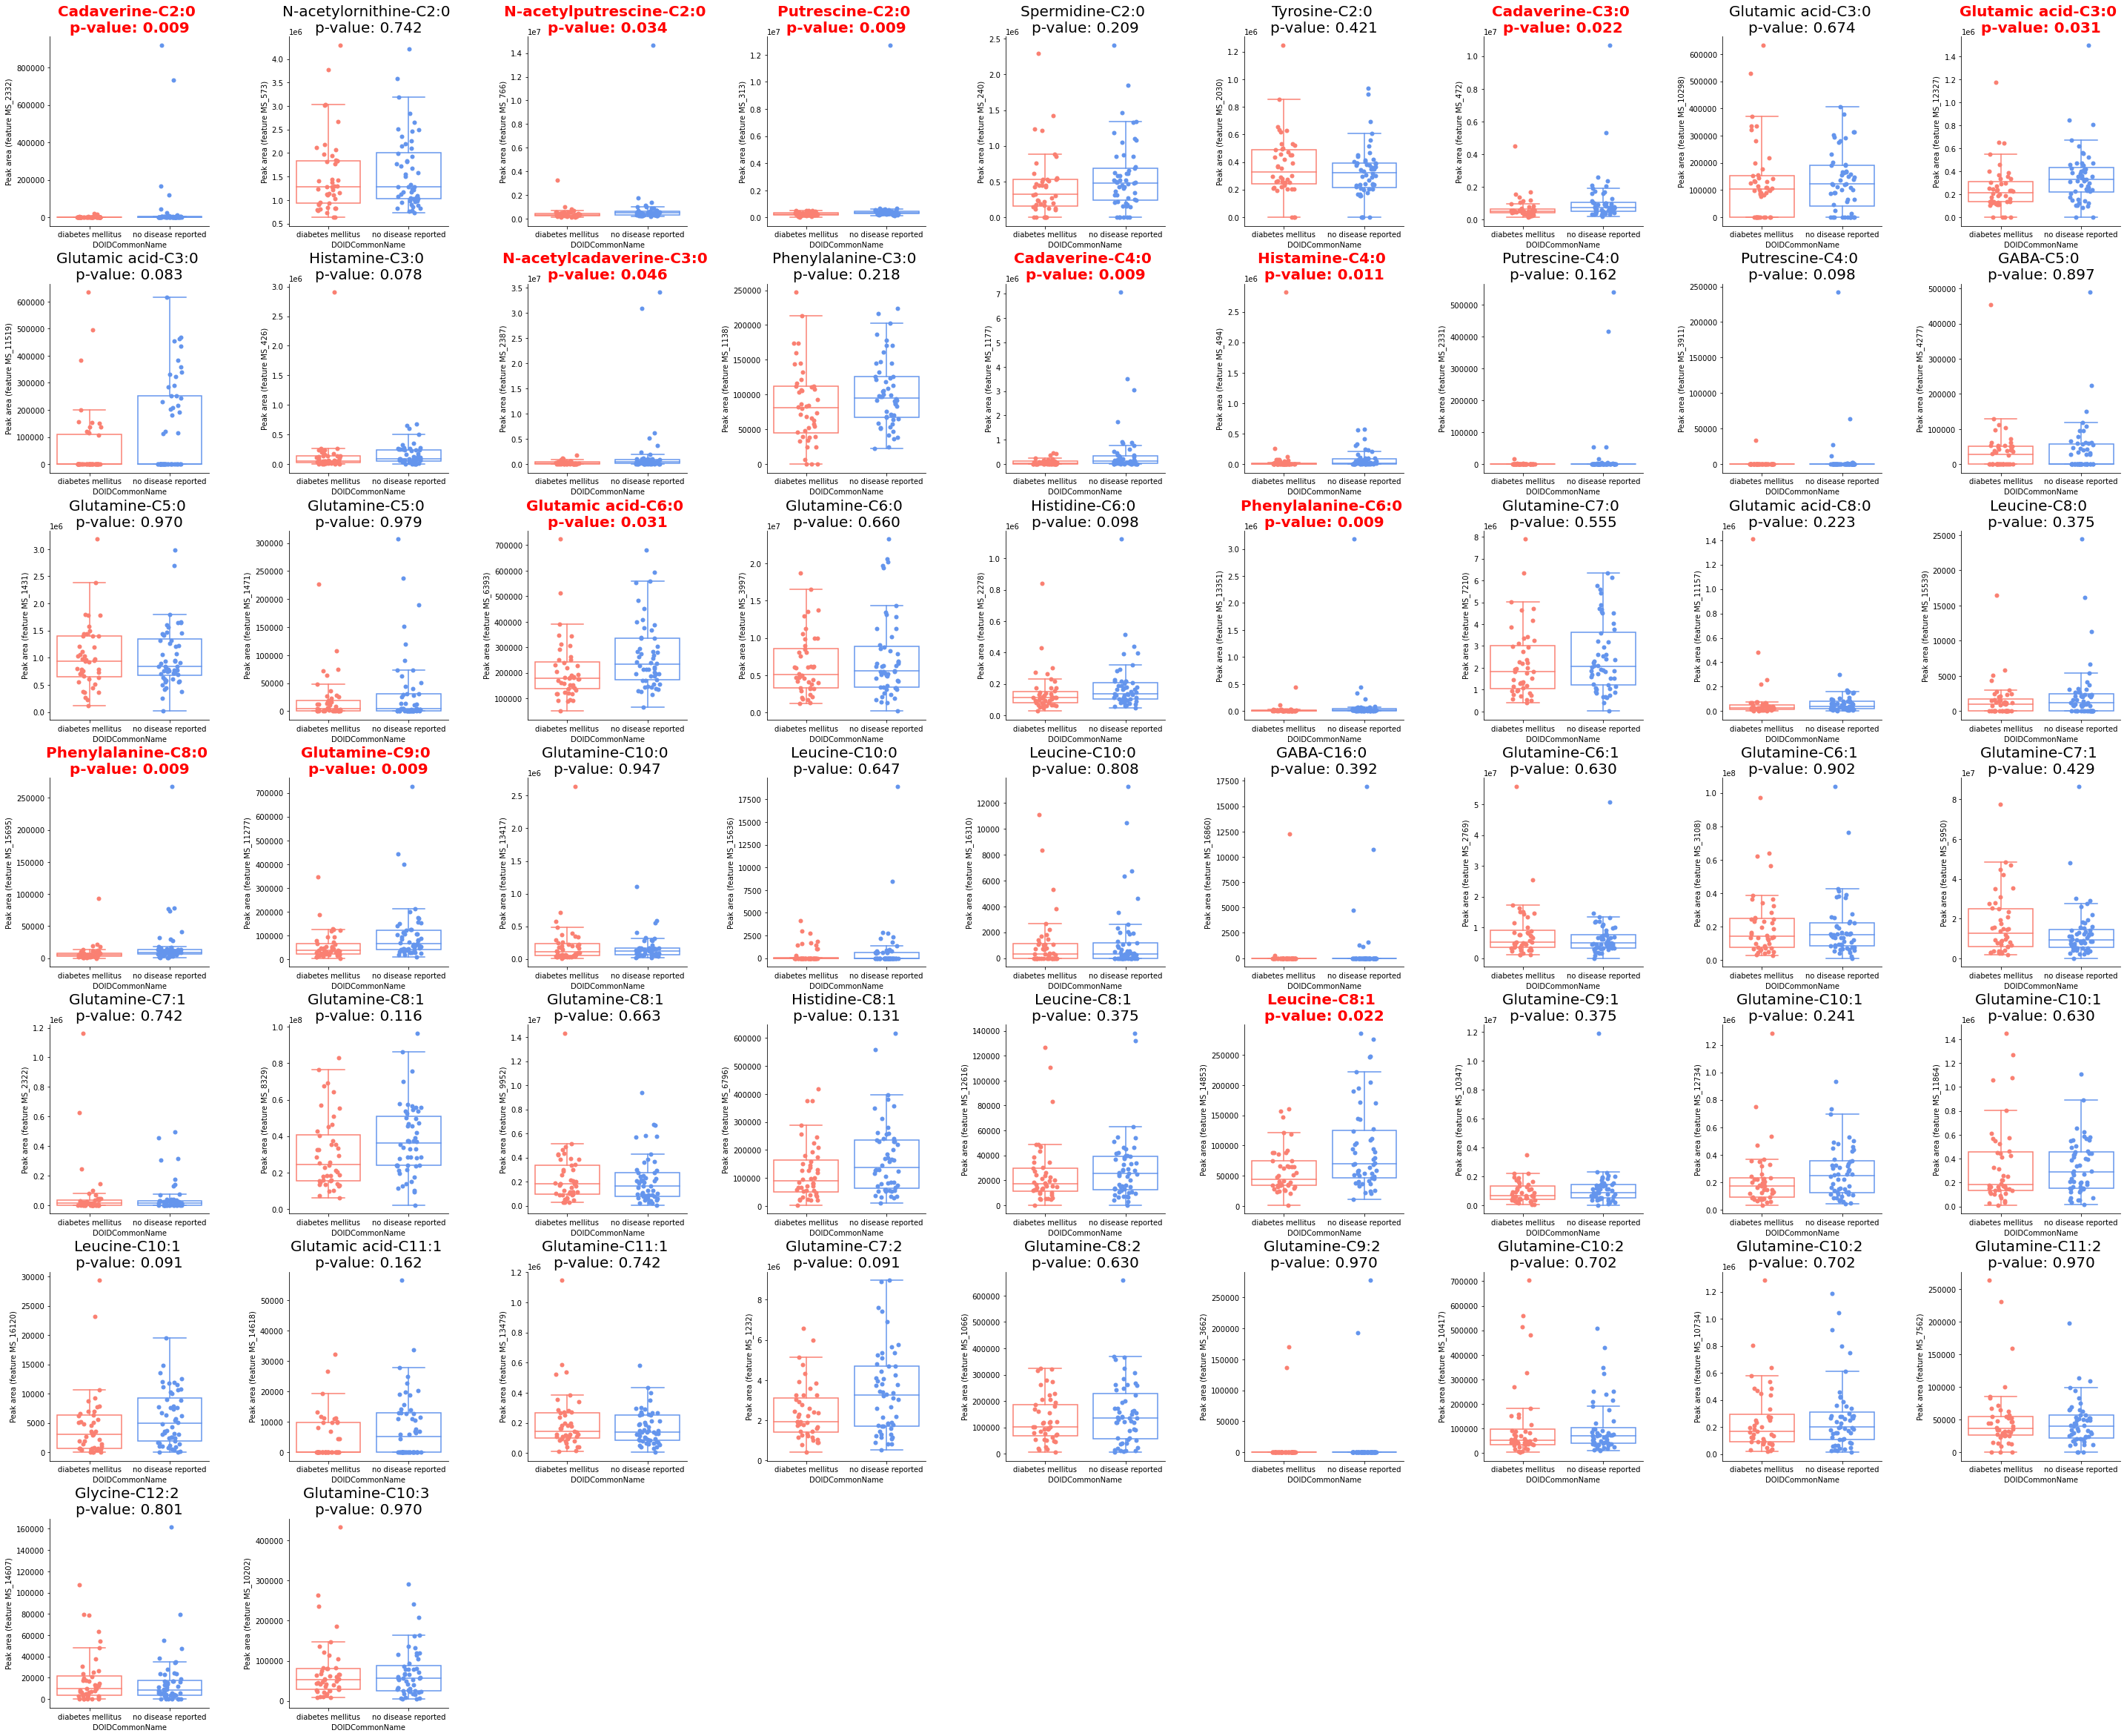

In [13]:
#reorganize the column order
metadata = pd.read_csv('/.../deltas_annotation_reordered.txt', sep='\t')
metadata['order'] = metadata['order'].astype(str).str.zfill(3)
ms_features = pd.DataFrame(ftable_filtered_merged.columns[2:], columns=['MS_#Scan#'])
ms_features = pd.merge(ms_features, library_matches[['MS_#Scan#', 'Compound_Name_simplified']], 
                       on='MS_#Scan#', how='left')
ms_features['annotation'] = ms_features['Compound_Name_simplified'].str.split('-').str[-1]
ms_features['annotation'] = ms_features['annotation'].str.replace(' ','')
ms_features = pd.merge(ms_features, metadata[['annotation','order']], on='annotation', how='left')
ms_features['order'] = ms_features['order'].astype(str) + '_'+ ms_features['Compound_Name_simplified'].str.split('-').str[0]
ms_features_reordered = ms_features.sort_values(by='order', ascending=True)

ordered_feature_names = ms_features_reordered['MS_#Scan#'].tolist()

# Placeholder dictionary to hold p-values
p_values = {}

# Assuming 'column_interest' splits the data into two groups
group_labels = ftable_filtered_merged[column_interest].unique()
if len(group_labels) != 2:
    raise ValueError("column_interest must divide the data into exactly two groups for a Mann-Whitney U test.")

for feature_name in ordered_feature_names:  # Use the ordered list for loop
    # Data for the two groups
    data_group1 = ftable_filtered_merged[ftable_filtered_merged[column_interest] == group_labels[0]][feature_name]
    data_group2 = ftable_filtered_merged[ftable_filtered_merged[column_interest] == group_labels[1]][feature_name]
    
    # Perform the Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(data_group1, data_group2, alternative='two-sided', use_continuity=True)
    p_values[feature_name] = p_value

# Exclude any NaN p-values before FDR correction
pvals = [p for p in p_values.values() if not np.isnan(p)]
features = [f for f, p in p_values.items() if not np.isnan(p)]

# Apply FDR correction
rej, pvals_corrected, _, _ = smm.multipletests(pvals, alpha=0.05, method='fdr_bh')

# Update the p_values dictionary with corrected p-values
corrected_p_values = dict(zip(features, pvals_corrected))
p_values.update(corrected_p_values)

#plot
plt.figure(figsize=(40, 60))  # Adjust the figure size as needed

my_pal = {'diabetes mellitus': 'salmon', 'no disease reported': 'cornflowerblue'}

for i, feature_name in enumerate(ordered_feature_names, 1):
    title_name = library_matches.loc[library_matches['MS_#Scan#'] == feature_name, 'Compound_Name_simplified'].iloc[0]
    plt.subplot(12, 9, i)
    fig = sns.boxplot(x=column_interest, y=feature_name, data=ftable_filtered_merged, notch=False, 
                      palette={'diabetes mellitus': 'white', 'no disease reported': 'white'}, showfliers=False)
    
    # Set box properties including edge color to match your palette
    for j, patch in enumerate(fig.artists):
        col = my_pal[ftable_filtered_merged[column_interest].unique()[j]]
        patch.set_edgecolor(col)

        num_lines = len(fig.lines)
        start_line_index = 5 * j
        end_line_index = start_line_index + 5
        for k in range(start_line_index, min(end_line_index, num_lines)):
            line = fig.lines[k]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Add colored dots for each category
    for diet in ftable_filtered_merged[column_interest].unique():
        sns.stripplot(
            x=column_interest, 
            y=feature_name, 
            data=ftable_filtered_merged[ftable_filtered_merged[column_interest] == diet], 
            color=my_pal[diet], 
            jitter=0.15, 
            size=6,
            ax=fig
        )
    # Determine title color based on p-value
    if p_values[feature_name] <= 0.05:
        title_color = 'red'
        title_weight = 'bold'
    else:
        title_color = 'black'
        title_weight = 'normal'
        
    fig.set_ylabel(f'Peak area (feature {feature_name})')
    plt.title(f'{title_name}\np-value: {p_values[feature_name]:.3f}', fontsize=20, color=title_color,
             fontweight=title_weight)  # Annotate with p-value
    
plt.tight_layout()
plt.subplots_adjust(top=0.91)
sns.despine()

plt.savefig("/.../Supplementary_Figure_3g.pdf.pdf")
plt.show()


In [ ]:
#all the ones significantly different between groups were subseted to be present in Supplementery Figure 3g.